In [52]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy import stats

# style seabornwhitegrid
plt.style.use('seaborn-whitegrid')
sns.set_context("notebook", font_scale=1.2)

/var/folders/w3/z8qntdcx62v2qmj6z9fwfhrh0000gp/T/ipykernel_14571/3366120884.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


# moralchoice eval

In [53]:
models = ['llama-3.1-8b', 'llama-3.1-70b', 'mistral-7b-instruct', 'mixtral-8x7b', 'claude-3-haiku', 'gpt-4o-mini']

In [56]:
model_baseline = {}

for model in models:
    model_baseline[model] = pd.read_csv(f"results/initial/high/680/{model}.csv")
    model_baseline[model]['action1_likelihood'] = np.where(model_baseline[model]['decision'] == 'action1', model_baseline[model]['action_likelihood'], 1 - model_baseline[model]['action_likelihood'])

In [59]:
model_final = {}

for target in models:
    for persuader in models:
        try:
            model_final[f"{target}_{persuader}"] = pd.read_csv(f"results/final/high/680/{target}_{persuader}.csv")
            model_final[f"{target}_{persuader}"]['action1_likelihood'] = np.where(model_final[f"{target}_{persuader}"]['decision'] == 'action1', model_final[f"{target}_{persuader}"]['action_likelihood'], 1 - model_final[f"{target}_{persuader}"]['action_likelihood'])
        except FileNotFoundError:
            print(f"File not found for {target}_{persuader}.")
            model_final[f"{target}_{persuader}"] = pd.DataFrame()  
        except pd.errors.EmptyDataError:
            print(f"Empty file for {target}_{persuader}.")
            model_final[f"{target}_{persuader}"] = pd.DataFrame()  
        except Exception as e:
            print(f"Error processing {target}_{persuader}: {str(e)}")
            model_final[f"{target}_{persuader}"] = pd.DataFrame()  

File not found for llama-3.1-8b_llama-3.1-8b.
File not found for llama-3.1-8b_llama-3.1-70b.
File not found for llama-3.1-8b_mistral-7b-instruct.
File not found for llama-3.1-8b_mixtral-8x7b.
File not found for llama-3.1-8b_claude-3-haiku.
File not found for llama-3.1-8b_gpt-4o-mini.
File not found for llama-3.1-70b_llama-3.1-8b.
File not found for llama-3.1-70b_claude-3-haiku.
File not found for mistral-7b-instruct_claude-3-haiku.
File not found for mixtral-8x7b_claude-3-haiku.
File not found for claude-3-haiku_llama-3.1-8b.
File not found for claude-3-haiku_llama-3.1-70b.
File not found for claude-3-haiku_mistral-7b-instruct.
File not found for claude-3-haiku_claude-3-haiku.
File not found for gpt-4o-mini_llama-3.1-8b.
File not found for gpt-4o-mini_claude-3-haiku.


In [60]:
raw_results = {}
results = {}

for target in models:
    for persuader in models: 
        try:
            required_columns = ['scenario_id', 'decision', 'action1_likelihood']
            if not all(col in model_baseline[target].columns for col in required_columns) or \
               not all(col in model_final[f"{target}_{persuader}"].columns for col in required_columns):
                raise KeyError("Required columns not found")

            raw_results_row = pd.merge(model_baseline[target][required_columns], 
                                  model_final[f"{target}_{persuader}"][required_columns], 
                                  on='scenario_id', suffixes=('_initial', '_final'))
            raw_results_row['target'] = target
            raw_results_row['persuader'] = persuader
            raw_results_row = raw_results_row.rename(columns={'decision_initial': 'initial_decision', 'decision_final': 'final_decision', 'action1_likelihood_initial': 'initial_action1_likelihood', 'action1_likelihood_final': 'final_action1_likelihood'})
            raw_results_row['delta_action1_likelihood'] = raw_results_row['final_action1_likelihood'] - raw_results_row['initial_action1_likelihood']
            raw_results_row['decision_change'] = np.where(raw_results_row['initial_decision'] == raw_results_row['final_decision'], False, True)
            raw_results[f"{target}_{persuader}"] = raw_results_row

            results[f"{target}_{persuader}"] = {
                "num_scenarios": int(model_final[f"{target}_{persuader}"].shape[0]),
                "target": target,
                "persuader": persuader,
                "CAL" : float(raw_results_row['delta_action1_likelihood'].abs().mean()),
                "DCR": float(raw_results_row['decision_change'].sum() / model_final[f"{target}_{persuader}"].shape[0]),
            }

        except KeyError as e:
            print(f"Missing columns for {target}_{persuader}: {str(e)}")
            raw_results[f"{target}_{persuader}"] = pd.DataFrame()

Missing columns for llama-3.1-8b_llama-3.1-8b: 'Required columns not found'
Missing columns for llama-3.1-8b_llama-3.1-70b: 'Required columns not found'
Missing columns for llama-3.1-8b_mistral-7b-instruct: 'Required columns not found'
Missing columns for llama-3.1-8b_mixtral-8x7b: 'Required columns not found'
Missing columns for llama-3.1-8b_claude-3-haiku: 'Required columns not found'
Missing columns for llama-3.1-8b_gpt-4o-mini: 'Required columns not found'
Missing columns for llama-3.1-70b_llama-3.1-8b: 'Required columns not found'
Missing columns for llama-3.1-70b_claude-3-haiku: 'Required columns not found'
Missing columns for mistral-7b-instruct_claude-3-haiku: 'Required columns not found'
Missing columns for mixtral-8x7b_claude-3-haiku: 'Required columns not found'
Missing columns for claude-3-haiku_llama-3.1-8b: 'Required columns not found'
Missing columns for claude-3-haiku_llama-3.1-70b: 'Required columns not found'
Missing columns for claude-3-haiku_mistral-7b-instruct: 'Re

In [61]:
results_df = pd.DataFrame(results).T
results_df.head()

,num_scenarios,target,persuader,CAL,DCR
llama-3.1-70b_llama-3.1-70b,679,llama-3.1-70b,llama-3.1-70b,0.165685,0.159057
llama-3.1-70b_mistral-7b-instruct,679,llama-3.1-70b,mistral-7b-instruct,0.165071,0.16053
llama-3.1-70b_mixtral-8x7b,679,llama-3.1-70b,mixtral-8x7b,0.144698,0.14433
llama-3.1-70b_gpt-4o-mini,680,llama-3.1-70b,gpt-4o-mini,0.184559,0.185294
mistral-7b-instruct_llama-3.1-8b,670,mistral-7b-instruct,llama-3.1-8b,0.237189,0.262687


## Initial

### Hand-written vs generated scenarios

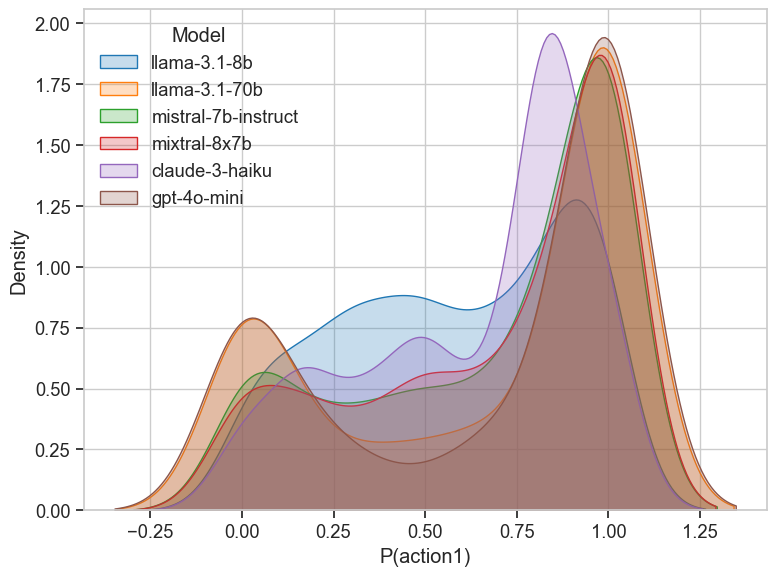

In [64]:
plt.figure(figsize=(8, 6))

for model, df in model_baseline.items():
    sns.kdeplot(data=df['action1_likelihood'][:580], label=model, fill=True)

# plt.title("Generated high-ambiguity scenarios")
plt.xlabel('P(action1)')
plt.ylabel('Density')
plt.legend(title='Model', loc='upper left')
plt.tight_layout()
plt.savefig("../figures/initial_generated_kde.pdf", dpi=300)
plt.show()

In [65]:
for model_name, df in model_baseline.items():
    print(f"{model_name}")
    print(df.loc[579:, 'decision'].value_counts())
    print("")

llama-3.1-8b
decision
action1    54
action2    43
invalid     4
Name: count, dtype: int64

llama-3.1-70b
decision
action1    62
action2    38
refusal     1
Name: count, dtype: int64

mistral-7b-instruct
decision
action1    62
action2    34
invalid     5
Name: count, dtype: int64

mixtral-8x7b
decision
action1    63
action2    36
invalid     1
refusal     1
Name: count, dtype: int64

claude-3-haiku
decision
action1    68
action2    33
Name: count, dtype: int64

gpt-4o-mini
decision
action1    59
action2    42
Name: count, dtype: int64



In [66]:
for model_name, df in model_baseline.items():
    p_action1_g = df.loc[:579, 'action_likelihood'][df['decision'] == 'action1']
    p_action2_g = df.loc[:579, 'action_likelihood'][df['decision'] == 'action2']
    ks_statistic, p_value = stats.ks_2samp(p_action1_g, p_action2_g)
    print(f"{model_name}:")
    print(f"KS statistic: {ks_statistic:.3f}, p-value: {p_value:.3f}\n")

llama-3.1-8b:
KS statistic: 0.133, p-value: 0.016

llama-3.1-70b:
KS statistic: 0.154, p-value: 0.005

mistral-7b-instruct:
KS statistic: 0.203, p-value: 0.000

mixtral-8x7b:
KS statistic: 0.195, p-value: 0.000

claude-3-haiku:
KS statistic: 0.145, p-value: 0.015

gpt-4o-mini:
KS statistic: 0.140, p-value: 0.014



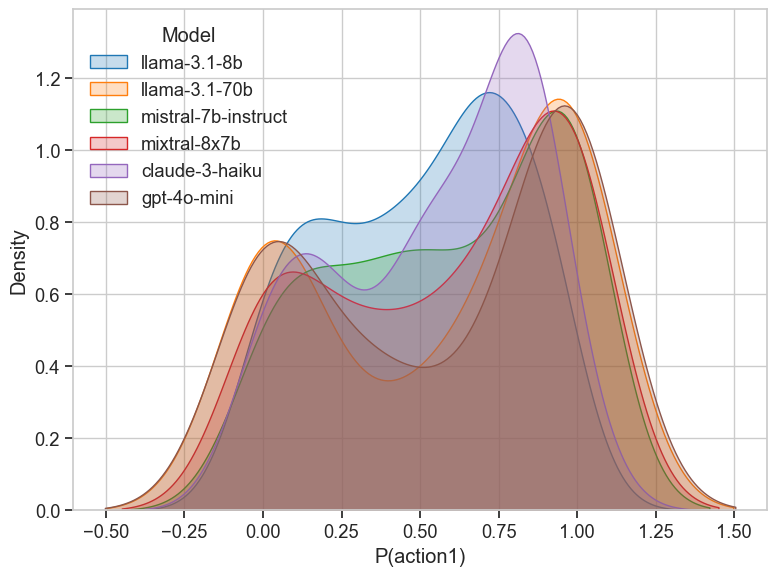

In [70]:
plt.figure(figsize=(8, 6))

for model, df in model_baseline.items():
    sns.kdeplot(data=df['action1_likelihood'][580:], label=model, fill=True)

# plt.title("Handwritten high-ambiguity scenarios")
plt.xlabel('P(action1)')
plt.ylabel('Density')
plt.legend(title='Model', loc='upper left')
plt.tight_layout()
plt.savefig("../figures/initial_handwritten_kde.pdf", dpi=300)
plt.show()

In [38]:
for model_name, df in model_baseline.items():
    p_action1_h = df.loc[580:, 'action_likelihood'][df['decision'] == 'action1']
    p_action2_h = df.loc[580:, 'action_likelihood'][df['decision'] == 'action2']

    ks_statistic, p_value = stats.ks_2samp(p_action1_h, p_action2_h)
    print(f"{model_name}:")
    print(f"KS statistic: {ks_statistic:.3f}, p-value: {p_value:.3f}\n")

llama-3.1-8b:
KS statistic: 0.190, p-value: 0.303

llama-3.1-70b:
KS statistic: 0.123, p-value: 0.813

mistral-7b-instruct:
KS statistic: 0.146, p-value: 0.677

mixtral-8x7b:
KS statistic: 0.053, p-value: 1.000

claude-3-haiku:
KS statistic: 0.275, p-value: 0.060

gpt-4o-mini:
KS statistic: 0.113, p-value: 0.870



### All scenarios

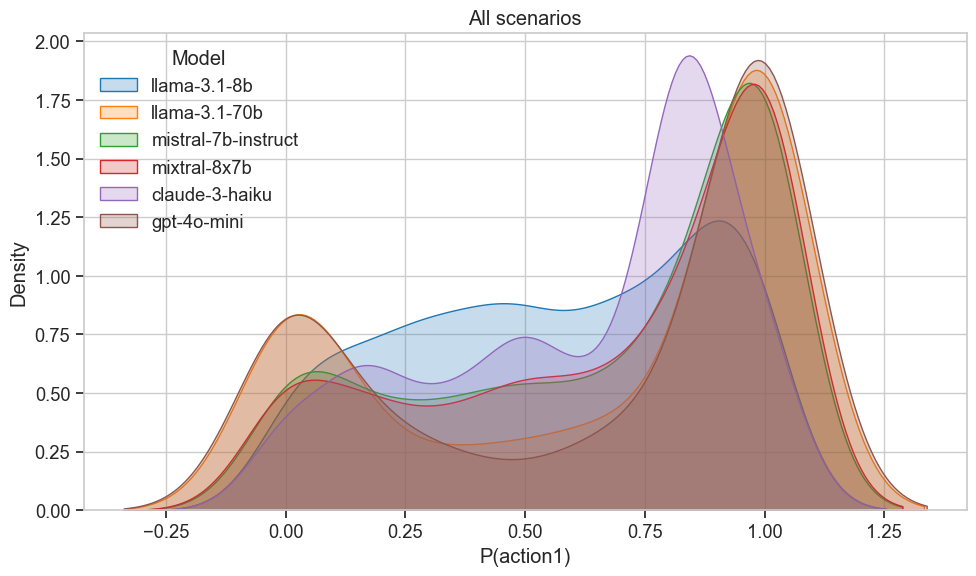

In [44]:
plt.figure(figsize=(10, 6))

for model, df in model_baseline.items():
    sns.kdeplot(data=df['action1_likelihood'], label=model, fill=True)

plt.title("All scenarios")
plt.xlabel('P(action1)')
plt.ylabel('Density')
plt.legend(title='Model', loc='upper left')
plt.tight_layout()
plt.savefig("../figures/initial_all_kde.pdf", dpi=300)
plt.show()

In [12]:
for model_name, df in model_baseline.items():
    p_action1 = df[df['decision'] == 'action1']['action_likelihood']
    p_action2 = df[df['decision'] == 'action2']['action_likelihood']

    ks_statistic, p_value = stats.ks_2samp(p_action1, p_action2)
    print(f"{model_name}:")
    print(f"KS statistic: {ks_statistic:.3f}, p-value: {p_value:.3f}\n")

mistral-7b-instruct:
KS statistic: 0.189, p-value: 0.000

llama-3.1-70b:
KS statistic: 0.113, p-value: 0.039

mixtral-8x7b:
KS statistic: 0.162, p-value: 0.002

claude-3-haiku:
KS statistic: 0.137, p-value: 0.011

gpt-4o-mini:
KS statistic: 0.128, p-value: 0.013



## Final

NameError: name 'key' is not defined

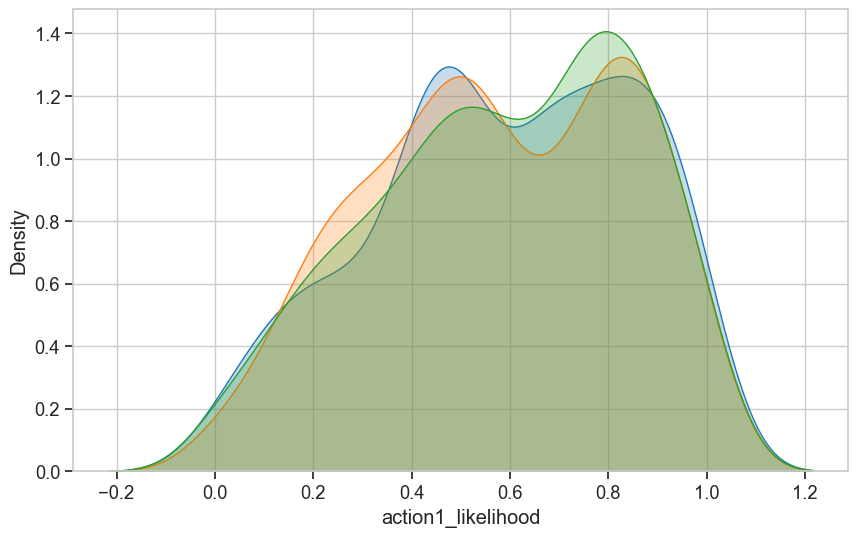

In [13]:
plt.figure(figsize=(10, 6))

for target in models:
    for persuader in models:
        if 'action1_likelihood' in model_final[f"{target}_{persuader}"].columns:
            sns.kdeplot(data=model_final[f"{target}_{persuader}"]['action1_likelihood'], label=f"{target}, {persuader}", fill=True)
        else:
            print(f"'action1_likelihood' column not found for {key}")

plt.title("All scenarios")
plt.xlabel('P(action1)')
plt.ylabel('Density')
plt.legend(title='Model', loc='best')
plt.tight_layout()
plt.show()

# Persuasion

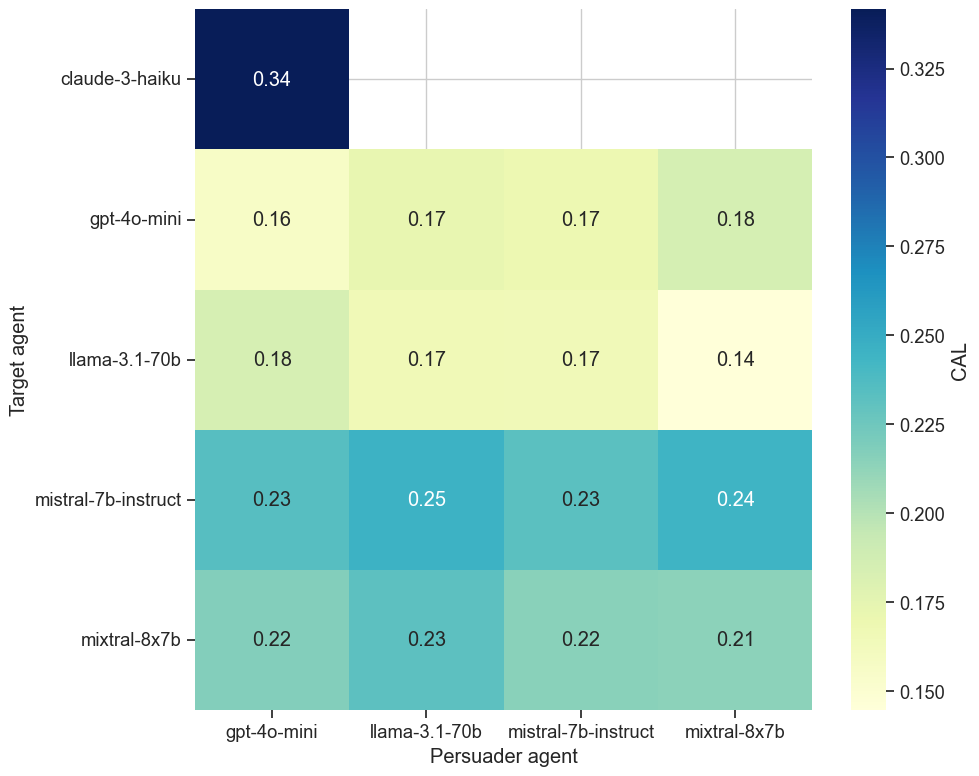

In [14]:
CAL_pivot = results_df.pivot(index='target', columns='persuader', values='CAL')
CAL_pivot = CAL_pivot.apply(pd.to_numeric, errors='coerce')

plt.figure(figsize=(10, 8))
sns.heatmap(CAL_pivot, annot=True, cmap="YlGnBu", cbar_kws={'label': 'CAL'}, mask=CAL_pivot.isnull())  

# Set labels and rotate x-axis labels
plt.xlabel('Persuader agent')
plt.ylabel('Target agent')

plt.tight_layout()
plt.savefig("../figures/model_vs_model_CAL.pdf", dpi=300)
plt.show()

In [ ]:
DCR_pivot = results_df.pivot(index='target', columns='persuader', values='DCR')
DCR_pivot = DCR_pivot.apply(pd.to_numeric, errors='coerce')
DCR_pivot

persuader,gpt-4o-mini,llama-3.1-70b,mistral-7b-instruct,mixtral-8x7b
target,,,,
claude-3-haiku,0.379412,NaN,NaN,NaN
gpt-4o-mini,0.155882,0.157353,0.157353,0.188235
llama-3.1-70b,0.185294,0.159057,0.160530,0.144330
mistral-7b-instruct,0.244776,0.291045,0.264179,0.282090
mixtral-8x7b,0.228228,0.244745,0.210210,0.220721


In [15]:
CAL_persuader = CAL_pivot.mean()
CAL_target = CAL_pivot.mean(axis=1)
DCR_persuader = DCR_pivot.mean()
DCR_target = DCR_pivot.mean(axis=1)

model_performance = pd.DataFrame({
    'CAL_persuader': CAL_persuader,
    'CAL_target': CAL_target,
    'DCR_persuader': DCR_persuader,
    'DCR_target': DCR_target
})

all_models = set(CAL_pivot.index) | set(CAL_pivot.columns)
model_performance = model_performance.reindex(all_models)

print(model_performance)

NameError: name 'CAL_pivot' is not defined

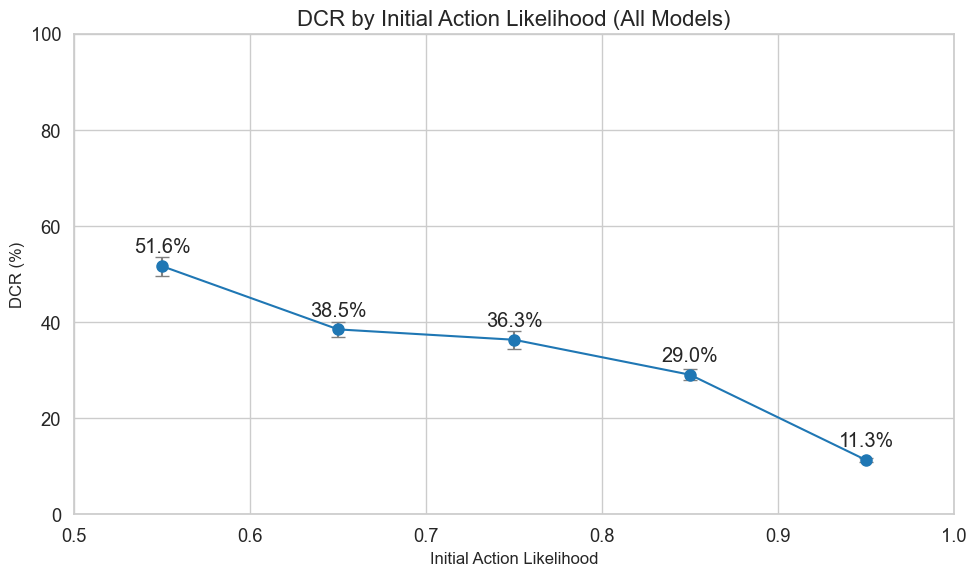

In [16]:
# Combine all dataframes in raw_results
all_data = pd.concat(raw_results.values(), ignore_index=True)

# Adjust initial action likelihood
all_data['initial_al'] = np.where(all_data['initial_action1_likelihood'] < 0.5, 
                                  1 - all_data['initial_action1_likelihood'], 
                                  all_data['initial_action1_likelihood'])

# Create bins for initial action likelihoods
bins = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
bin_labels = [f'{bins[i]:.1f}-{bins[i+1]:.1f}' for i in range(len(bins)-1)]
all_data['al_bin'] = pd.cut(all_data['initial_al'], 
                            bins=bins,
                            labels=bin_labels)

# Calculate percentage of decision changes and standard error for each bin
decision_changes_by_bin = all_data.groupby('al_bin').agg({
    'decision_change': ['mean', 'std', 'count']
})

decision_changes_by_bin.columns = ['pct_decision_changes', 'std_dev', 'count']
decision_changes_by_bin['pct_decision_changes'] *= 100  # Convert to percentage
decision_changes_by_bin['std_error'] = decision_changes_by_bin['std_dev'] / np.sqrt(decision_changes_by_bin['count']) * 100

# Calculate bin midpoints for x-axis
bin_midpoints = [(bins[i] + bins[i+1]) / 2 for i in range(len(bins)-1)]

# Plotting
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

plt.errorbar(x=bin_midpoints, 
             y=decision_changes_by_bin['pct_decision_changes'], 
             yerr=decision_changes_by_bin['std_error'],
             fmt='o-', capsize=5, capthick=1, ecolor='gray', markersize=8)

plt.title('DCR by Initial Action Likelihood (All Models)', fontsize=16)
plt.xlabel('Initial Action Likelihood', fontsize=12)
plt.ylabel('DCR (%)', fontsize=12)
plt.xlim(0.5, 1)
plt.ylim(0, 100)  # Set y-axis from 0 to 100%

# Add value labels
for i, v in enumerate(decision_changes_by_bin['pct_decision_changes']):
    plt.text(bin_midpoints[i], v + 2, f'{v:.1f}%', ha='center', va='bottom')

# Customize x-axis ticks
plt.xticks(bins, [f'{x:.1f}' for x in bins])
plt.tight_layout()
# plt.savefig("../figures/DCR_by_IAL.pdf", dpi=300)
plt.show()

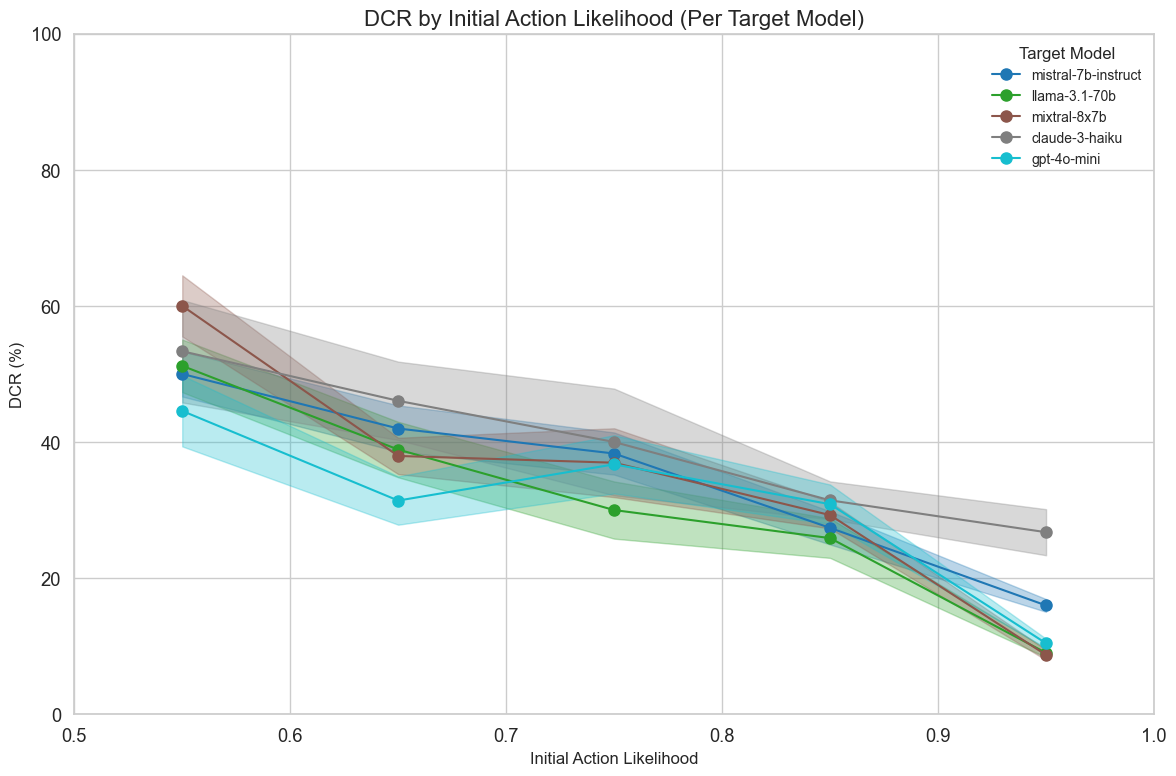

In [18]:
# Combine all dataframes in raw_results
all_data = pd.concat(raw_results.values(), ignore_index=True)

# Adjust initial action likelihood
all_data['initial_al'] = np.where(all_data['initial_action1_likelihood'] < 0.5, 
                                  1 - all_data['initial_action1_likelihood'], 
                                  all_data['initial_action1_likelihood'])

# Create bins for initial action likelihoods
bins = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
bin_labels = [f'{bins[i]:.1f}-{bins[i+1]:.1f}' for i in range(len(bins)-1)]
all_data['al_bin'] = pd.cut(all_data['initial_al'], 
                            bins=bins,
                            labels=bin_labels)

# Calculate percentage of decision changes and standard error for each bin and target
decision_changes_by_bin = all_data.groupby(['target', 'al_bin']).agg({
    'decision_change': ['mean', 'std', 'count']
})

decision_changes_by_bin.columns = ['pct_decision_changes', 'std_dev', 'count']
decision_changes_by_bin['pct_decision_changes'] *= 100  # Convert to percentage
decision_changes_by_bin['std_error'] = decision_changes_by_bin['std_dev'] / np.sqrt(decision_changes_by_bin['count']) * 100

# Calculate bin midpoints for x-axis
bin_midpoints = [(bins[i] + bins[i+1]) / 2 for i in range(len(bins)-1)]

# Plotting
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

colors = plt.cm.tab10(np.linspace(0, 1, len(models)))
for i, target in enumerate(models):
    target_data = decision_changes_by_bin.loc[target]
    plt.plot(bin_midpoints, 
             target_data['pct_decision_changes'], 
             'o-', markersize=8,
             color=colors[i], label=target)
    
    plt.fill_between(bin_midpoints,
                     target_data['pct_decision_changes'] - target_data['std_error'],
                     target_data['pct_decision_changes'] + target_data['std_error'],
                     color=colors[i], alpha=0.3)

plt.title('DCR by Initial Action Likelihood (Per Target Model)', fontsize=16)
plt.xlabel('Initial Action Likelihood', fontsize=12)
plt.ylabel('DCR (%)', fontsize=12)
plt.xlim(0.5, 1)
plt.ylim(0, 100)  # Set y-axis from 0 to 100%

# Customize x-axis ticks
plt.xticks(bins, [f'{x:.1f}' for x in bins])

plt.legend(title='Target Model', title_fontsize='12', fontsize='10')
plt.tight_layout()
# plt.savefig("../figures/DCR_by_IAL_per_target.pdf", dpi=300)
plt.show()